# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Train DDPG Agent

In [5]:
from agent_ddpg import Agent
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

weights_actor = "weights_actor.pth"
weights_critic = "weights_critic.pth"

Episode 25	Average score: 2.76	Score: 7.507
Episode 50	Average score: 7.58	Score: 15.946
Episode 75	Average score: 13.43	Score: 28.739
Episode 100	Average score: 18.67	Score: 34.830
Episode 125	Average score: 26.91	Score: 36.068
Episode 137	Average score: 30.09	Score: 36.112

Environment solved in 137 episodes!	Average score: 30.09


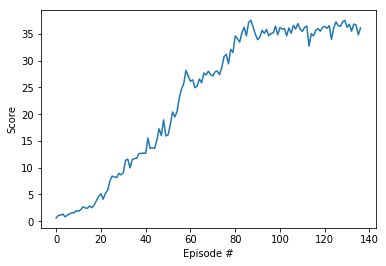

In [6]:
from collections import deque
import matplotlib.pyplot as plt
import torch
import workspace_utils as wu

%matplotlib inline

def ddpg(environment, agent, weights_actor, weights_critic, n_episodes=300, max_t=1000):
    """Deep Deterministic Policy Gradient Learning for the given agent in the given environment.

    Params
    ======
        environment (UnityEnvironment): environment
        agent (Agent): Agent object representing the parallel agents
        weights_actor (str): file containing the weights for the actor
        weights_critic (str): file containing the weights for the critic
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of time steps per episode
    """
    brain_name = environment.brain_names[0]

    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    for i_episode in range(1, n_episodes + 1):
        environment_info = environment.reset(train_mode=True)[brain_name]  # reset the environment
        state = environment_info.vector_observations
        score = np.zeros(agent.num_agents)

        for t in range(max_t):
            action = agent.act(state)
            environment_info = environment.step(action)[brain_name]  # send the action to the environment
            next_state = environment_info.vector_observations
            rewards = environment_info.rewards
            dones = environment_info.local_done
            agent.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards

            if np.any(dones):
                print('\tSteps: ', t)
                break

        scores_window.append(np.mean(score))
        scores.append(np.mean(score))

        print('\rEpisode {}\tAverage score: {:.2f}\tScore: {:.3f}'.format(i_episode, np.mean(scores_window), np.mean(score)), end='')
        average_score = np.mean(scores_window)

        if i_episode % 25 == 0 or average_score > 30:
            print('\rEpisode {}\tAverage score: {:.2f}'.format(i_episode, average_score))
            torch.save(agent.actor_local.state_dict(), '{}'.format(weights_actor))
            torch.save(agent.critic_local.state_dict(), '{}'.format(weights_critic))

        if average_score >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage score: {:.2f}'.format(i_episode, average_score))
            break

    return scores

with wu.active_session():
    scores = ddpg(env,agent, weights_actor, weights_critic)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Test trained Agent

In [5]:
def test_agent(environment, agent, max_t=1000):
    brain_name = environment.brain_names[0]
    environment_info = environment.reset(train_mode=False)[brain_name]
    states = environment_info.vector_observations
    scores = np.zeros(agent.num_agents)

    for t in range(max_t):
        actions = agent.act(states)
        environment_info = environment.step(actions)[brain_name]
        next_states = environment_info.vector_observations
        rewards = environment_info.rewards
        dones = environment_info.local_done
        scores += rewards
        states = next_states

        if np.any(dones):
            break

    print('Score: {}'.format(np.mean(scores)))

In [6]:
from agent_ddpg import Agent
import torch

# Set up the test agent
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

# Load the network weights
agent.actor_local.load_state_dict(torch.load("weights_actor.pth"))
agent.critic_local.load_state_dict(torch.load("weights_critic.pth"))

# Test the agent
test_agent(environment=env, agent=agent)

Score: 36.385999186709526


In [7]:
env.close()